In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from scipy.stats import linregress

In [2]:
df = pd.read_csv('netflix_titles.csv', index_col=0)

In [3]:
df.shape

(8807, 11)

In [4]:
df.drop_duplicates(inplace=True)
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce', format='%B %d, %Y')


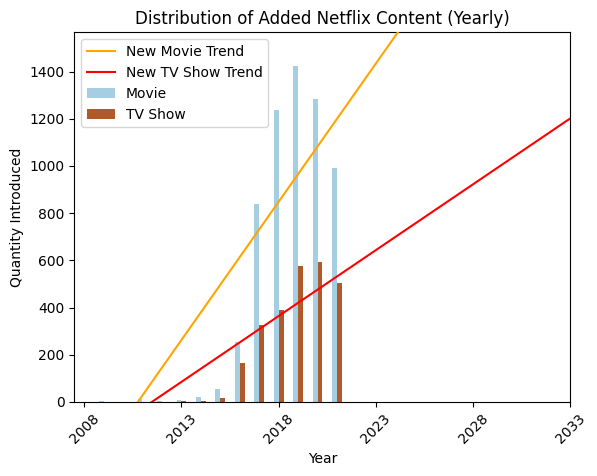

In [5]:
df_content_type = df.groupby([df['date_added'].dt.year, df['type']]).size().unstack()
fig, ax = plt.subplots()
df_content_type.plot(kind='bar', colormap='Paired', ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Quantity Introduced')
ax.set_title('Distribution of Added Netflix Content (Yearly)')
years = df_content_type.index.astype(int).values
x_normalized = np.arange(len(years))
x_actual = years
# Movie Regression
y_movie = df_content_type['Movie'].values
slope_movie = linregress(x=x_normalized, y=y_movie).slope
intercept_movie = linregress(x=x_normalized, y=y_movie).intercept
# TV Show Regression
y_tv_show = df_content_type['TV Show'].values
mask_tv = ~np.isnan(y_tv_show)
slope_tv_show = linregress(x=x_normalized[mask_tv], y=y_tv_show[mask_tv]).slope
intercept_tv_show = linregress(x=x_normalized[mask_tv], y=y_tv_show[mask_tv]).intercept

start_year = years[0]
end_year = 2035
years_future = np.arange(start_year, end_year + 1)
x_future_norm = years_future - start_year

regression_movie = slope_movie * x_future_norm + intercept_movie
regression_tv = slope_tv_show * x_future_norm + intercept_tv_show

ax.plot(x_future_norm, regression_movie, label='New Movie Trend', color='orange', zorder=3)
ax.plot(x_future_norm, regression_tv, label='New TV Show Trend', color='red', zorder=3)

tick_positions = np.arange(0, len(years_future), 5)
tick_labels = years_future[tick_positions]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)
ax.set_ylim(0, max(df_content_type.max()) * 1.1)

ax.set_ylim(bottom=0)
ax.legend()




C:\Users\Alex\AppData\Local\Temp\ipykernel_1976\2801869854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre['listed_in'] = df_genre['listed_in'].str.split(', ')


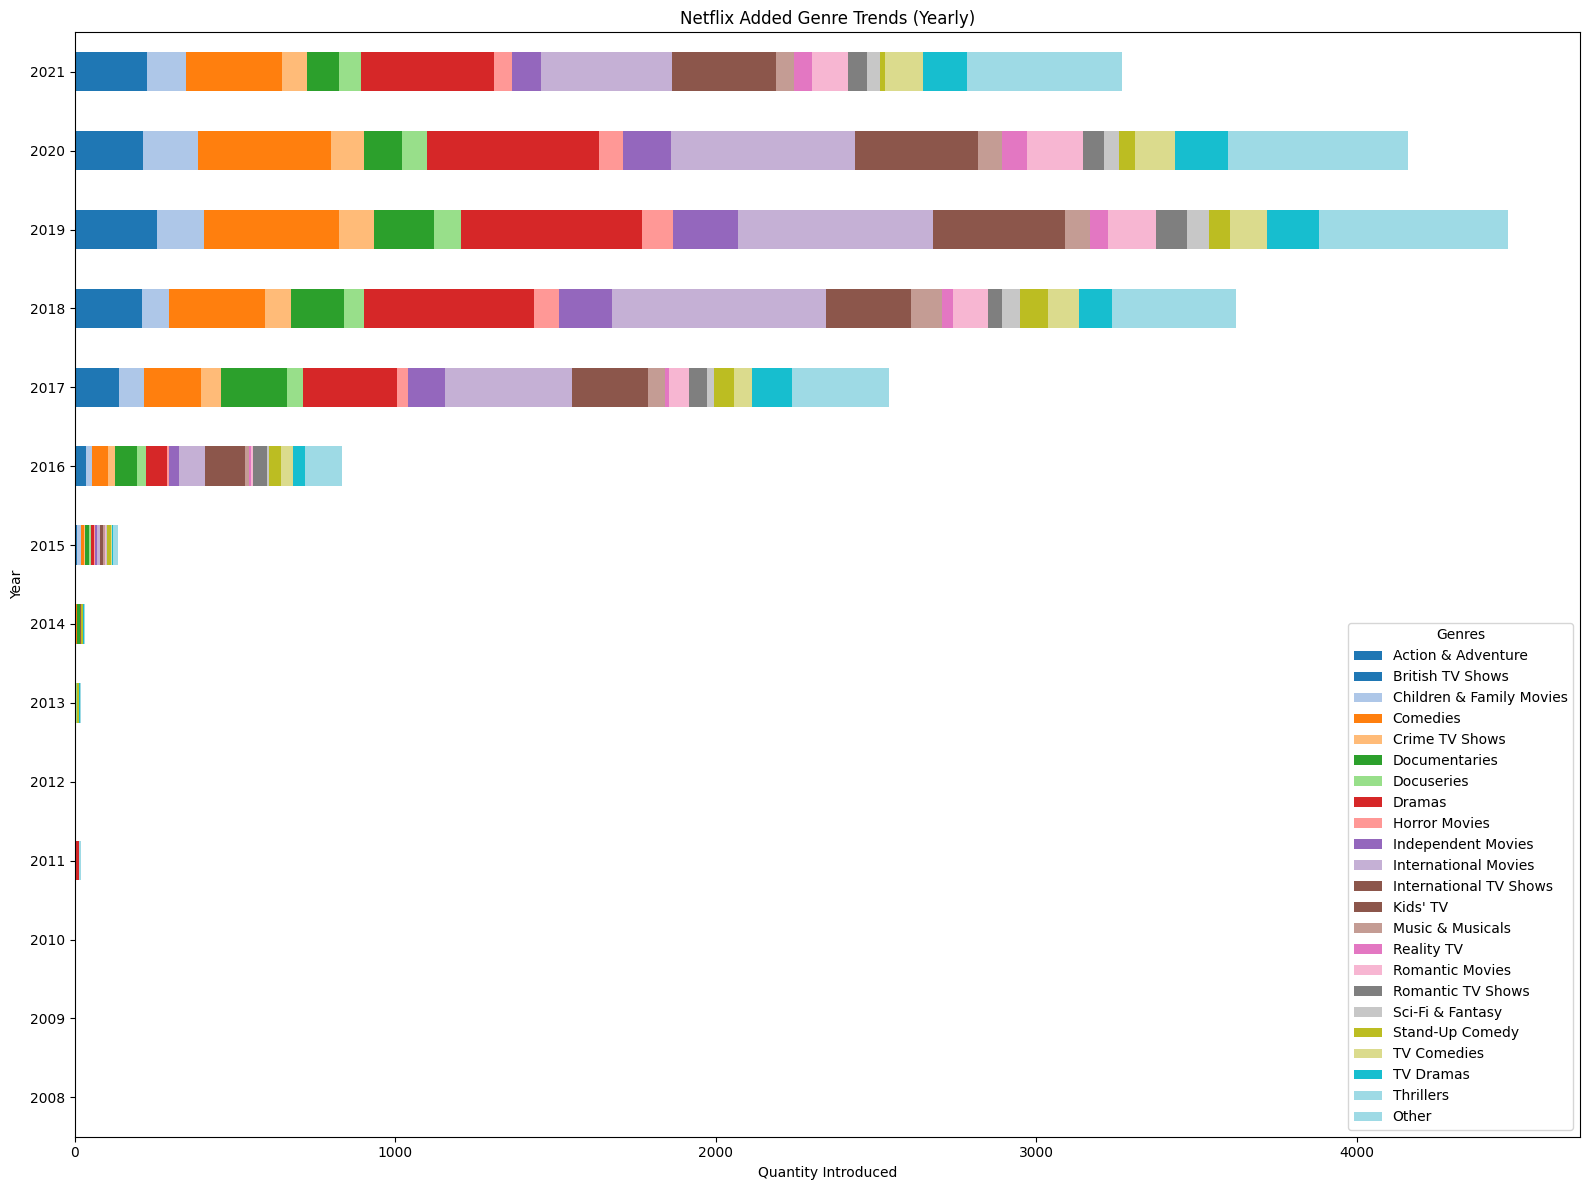

In [6]:
df_genre = df[~df['listed_in'].isna() & ~df['date_added'].isna()]
df_genre['listed_in'] = df_genre['listed_in'].str.split(', ')
df_genre = df_genre[['listed_in', 'date_added']]
df_genre = df_genre.explode('listed_in')
df_genre = df_genre.groupby([df_genre['date_added'].dt.year, df_genre['listed_in']]).size().unstack()

threshold = 230
rare_cols = [col for col in df_genre.columns if df_genre[col].sum() < threshold]
df_genre['Other'] = df_genre[rare_cols].sum(axis=1)
df_genre = df_genre.drop(columns=rare_cols)

fig, ax = plt.subplots(figsize=(16, 12))
df_genre.plot(kind='barh', stacked=True, ax=ax, colormap='tab20')
ax.set_title('Netflix Added Genre Trends (Yearly)')
ax.set_xlabel('Quantity Introduced')
ax.set_ylabel('Year')
plt.legend(title='Genres')
plt.tight_layout()



C:\Users\Alex\AppData\Local\Temp\ipykernel_1976\3044544583.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movie['duration'] = df_movie['duration'].str.strip(' min')
C:\Users\Alex\AppData\Local\Temp\ipykernel_1976\3044544583.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tv_show['duration'] = df_tv_show['duration'].str.strip(' Seasons')
C:\Users\Alex\AppData\Local\Temp\ipykernel_1976\3044544583.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

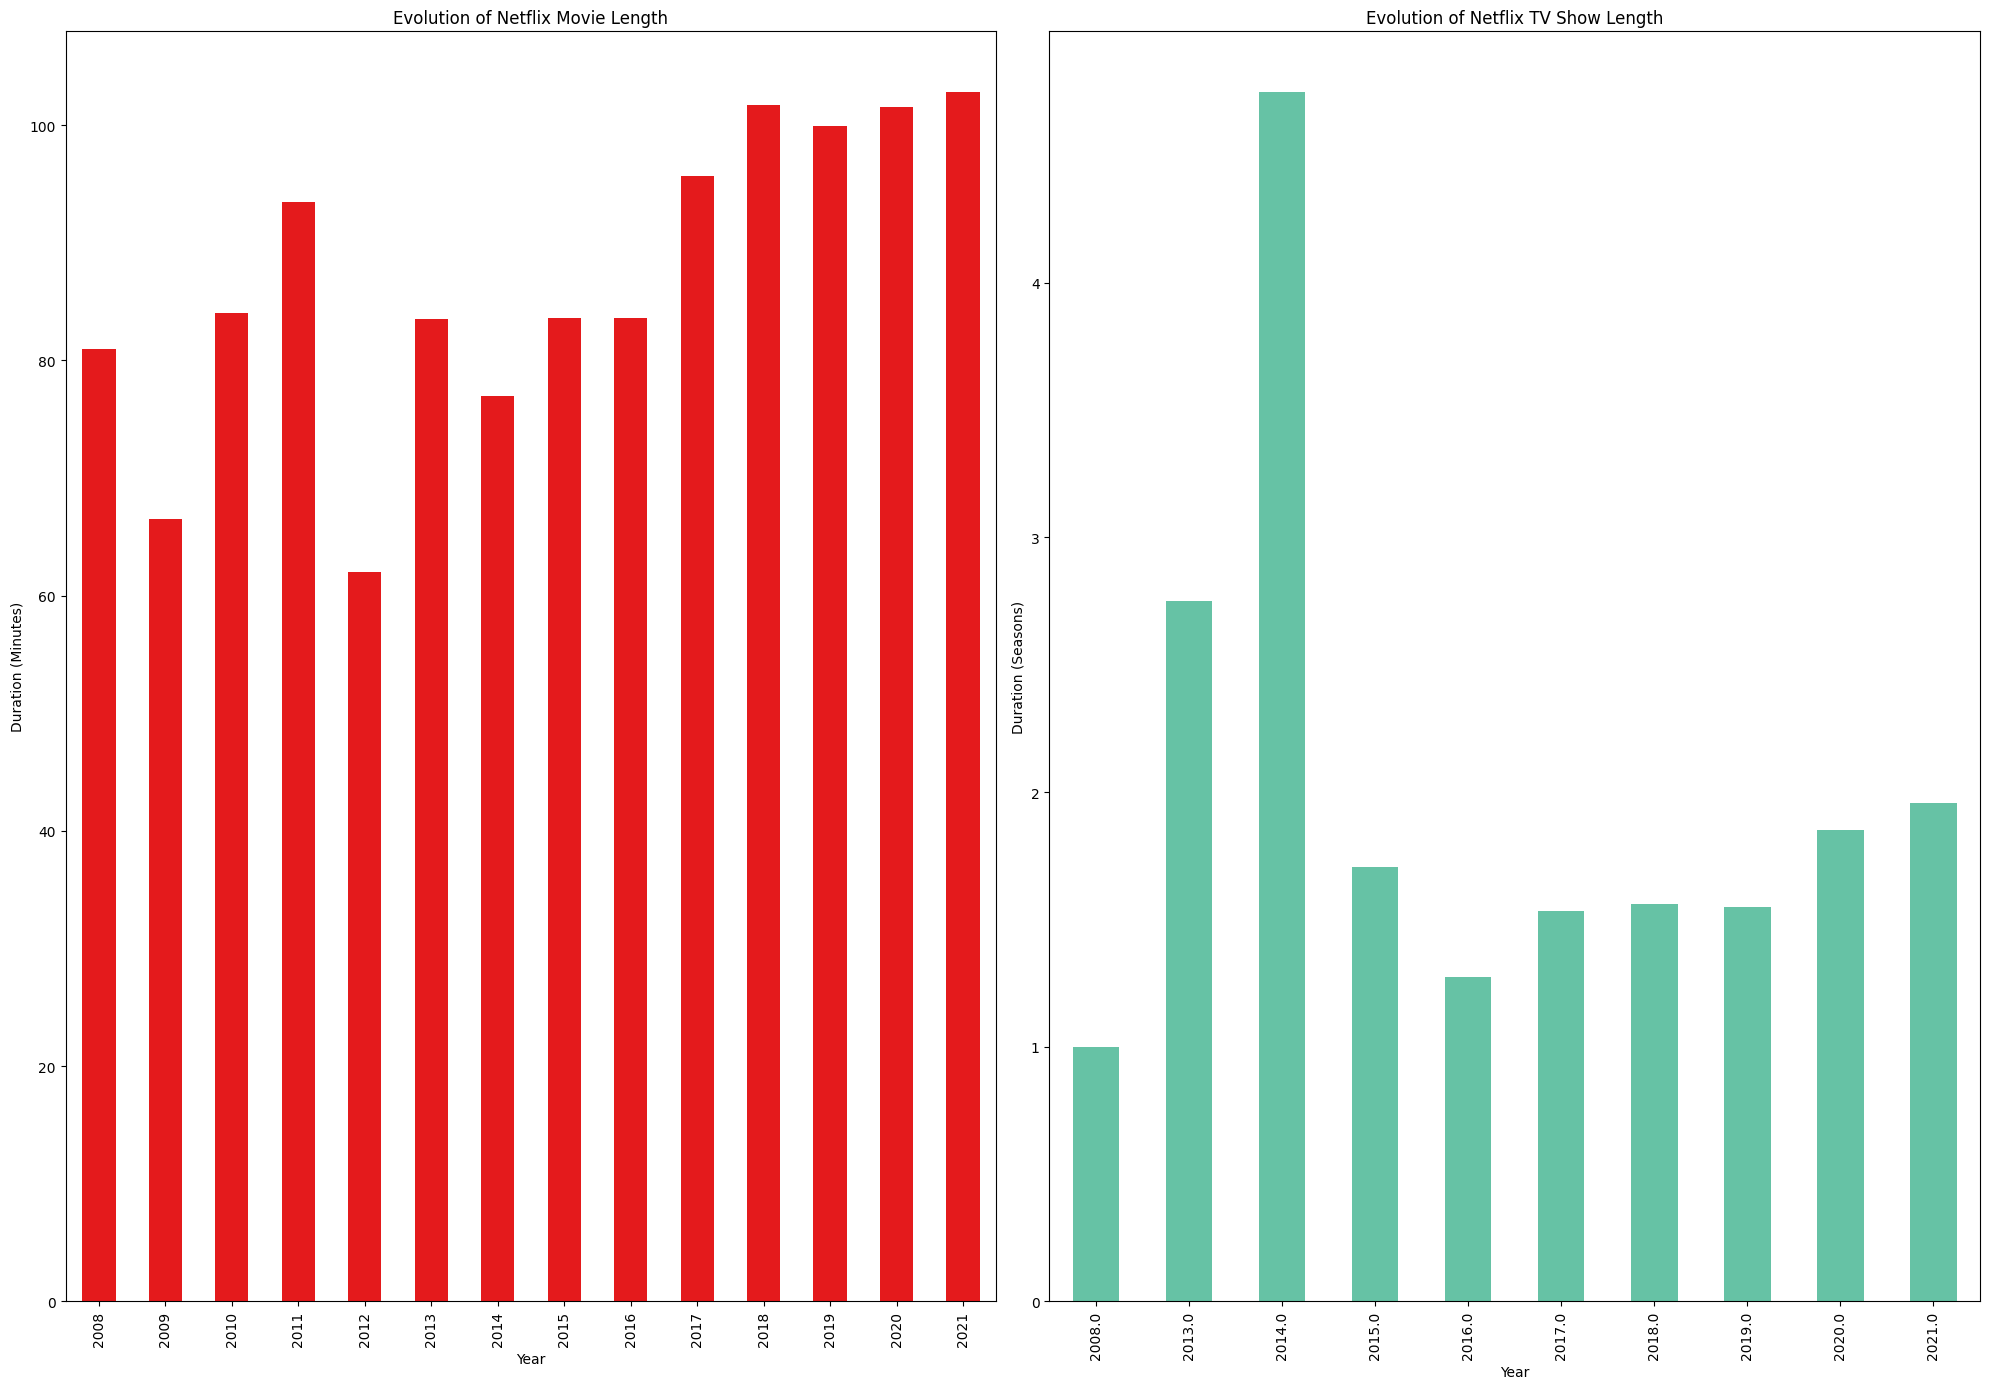

In [7]:
duration_mask = ~df['duration'].isna()
df_cleaned_duration = df[duration_mask]
movie_mask = df_cleaned_duration['type'] == 'Movie'
tv_show_mask = df_cleaned_duration['type'] == 'TV Show'
df_movie = df_cleaned_duration[movie_mask]
df_movie['duration'] = df_movie['duration'].str.strip(' min')
df_tv_show = df_cleaned_duration[tv_show_mask]
df_tv_show['duration'] = df_tv_show['duration'].str.strip(' Seasons')
df_movie['duration'] = pd.to_numeric(df_movie['duration'])
df_tv_show['duration'] = pd.to_numeric(df_tv_show['duration'])
df_movie = df_movie.groupby(df_movie['date_added'].dt.year)['duration'].mean()
df_tv_show = df_tv_show.groupby(df_tv_show['date_added'].dt.year)['duration'].mean()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,14))
df_movie.plot(kind='bar', colormap='Set1', ax=ax[0])
df_tv_show.plot(kind='bar', colormap='Set2', ax=ax[1])
ax[0].set_xlabel('Year')
ax[1].set_xlabel('Year')
ax[0].set_ylabel('Duration (Minutes)')
ax[0].set_title('Evolution of Netflix Movie Length')
ax[1].set_ylabel('Duration (Seasons)')
ax[1].set_title('Evolution of Netflix TV Show Length')
plt.tight_layout()
